In [36]:
# 匯入相關所需的模組
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
import pickle
import h5py
import glob
import time
from random import shuffle
from collections import Counter

from sklearn.model_selection import train_test_split

import keras 
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import LearningRateScheduler, ModelCheckpoint ,EarlyStopping
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.optimizers import SGD, Adam



In [37]:
#印出目前工作目錄
#print(os.getcwd())  
data_dir_path='/data/examples/may_the_4_be_with_u/where_am_i'
imgsPath =data_dir_path+'/train'
mappingPath =data_dir_path+ '/mapping.txt'
imgsPath

'/data/examples/may_the_4_be_with_u/where_am_i/train'

In [38]:
'''
map_characters = { 9:'CALsuburb' ,
                   7:'PARoffice' ,
                  12:'bedroom',
                  10:'coast' ,
                   4:'forest' ,
                  14:'highway' ,
                   2:'industrial' ,
                   3:'insidecity' ,
                   0:'kitchen'   ,
                   5:'livingroom' ,
                   8:'mountain'  ,
                   6:'opencountry' ,
                  11:'store'  ,
                   1:'street'  ,
                  13:'tallbuilding'}
'''

"\nmap_characters = { 9:'CALsuburb' ,\n                   7:'PARoffice' ,\n                  12:'bedroom',\n                  10:'coast' ,\n                   4:'forest' ,\n                  14:'highway' ,\n                   2:'industrial' ,\n                   3:'insidecity' ,\n                   0:'kitchen'   ,\n                   5:'livingroom' ,\n                   8:'mountain'  ,\n                   6:'opencountry' ,\n                  11:'store'  ,\n                   1:'street'  ,\n                  13:'tallbuilding'}\n"

In [39]:
map_characters ={}

with open(mappingPath) as pf:
    for line in pf:
        (key, val) = line.split(',')
        #map_characters[key] = int(val)
        map_characters[int(val)] = key
        
        
print(map_characters)

{9: 'CALsuburb', 7: 'PARoffice', 12: 'bedroom', 10: 'coast', 4: 'forest', 14: 'highway', 2: 'industrial', 3: 'insidecity', 0: 'kitchen', 5: 'livingroom', 8: 'mountain', 6: 'opencountry', 11: 'store', 1: 'street', 13: 'tallbuilding'}


In [47]:
img_width = 224
img_height = 224

num_classes = len(map_characters) # 要辨識的角色種類

#pictures_per_class = 1000 # 每個角色會有接近1000張訓練圖像
test_size = 0.15



In [48]:
# 將訓練資料圖像從檔案系統中取出並進行
def load_pictures():
    pics = []
    labels = []
    
    for k, v in map_characters.items(): # k: 數字編碼 v: 角色label
        # 把某一個角色在檔案夾裡的所有圖像檔的路徑捉出來
        pictures = [k for k in glob.glob(imgsPath + "/" + v + "/*.jpg")]        
        print(v + " : " + str(len(pictures))) # 看一下每個角色有多少訓練圖像
        for i, pic in enumerate(pictures):
            tmp_img = cv2.imread(pic)  # to gray
           
            # 由於OpenCv讀圖像時是以BGR (Blue-Green-Red), 我們把它轉置成RGB (Red-Green-Blue)
            tmp_img = cv2.cvtColor(tmp_img, cv2.COLOR_BGR2RGB)
            #tmp_img = cv2.cvtColor(tmp_img, cv2.COLOR_BGR2GRAY)
            
            tmp_img = cv2.resize(tmp_img, (img_height, img_width )) # 進行大小歸一位  
            #tmp_img = np.expand_dims(tmp_img, axis=2) #增加一個維度
            
            pics.append(tmp_img)
            labels.append(k)    
    return np.array(pics), np.array(labels)


# 取得訓練資料集與驗證資料集
def get_dataset(save=False, load=False):
    if load: 
        # 從檔案系統中載入之前處理保存的訓練資料集與驗證資料集
        h5f = h5py.File('dataset.h5','r')
        X_train = h5f['X_train'][:]
        X_test = h5f['X_test'][:]
        h5f.close()
        
        # 從檔案系統中載入之前處理保存的訓練資料標籤與驗證資料集籤
        h5f = h5py.File('labels.h5', 'r')
        y_train = h5f['y_train'][:]
        y_test = h5f['y_test'][:]
        h5f.close()
    else:
        # 從最原始的圖像檔案開始處理
        X, y = load_pictures()
        y = keras.utils.to_categorical(y, num_classes) # 目標的類別種類數
        
        # 將資料切分為訓練資料集與驗證資料集 (85% vs. 15%)
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size ,shuffle = 'true') 
        if save: # 保存尚未進行歸一化的圖像數據
            h5f = h5py.File('dataset.h5', 'w')
            h5f.create_dataset('X_train', data=X_train)
            h5f.create_dataset('X_test', data=X_test)
            h5f.close()
            
            h5f = h5py.File('labels.h5', 'w')
            h5f.create_dataset('y_train', data=y_train)
            h5f.create_dataset('y_test', data=y_test)
            h5f.close()
    
    # 進行圖像每個像素值的型別轉換與歸一化處理
    X_train = X_train.astype('float32') / 255.
    X_test = X_test.astype('float32') / 255.
    print("Train", X_train.shape, y_train.shape)
    print("Test", X_test.shape, y_test.shape)
    
    return X_train, X_test, y_train, y_test   

In [49]:
# 取得訓練資料集與驗證資料集  
X_train, X_test, y_train, y_test = get_dataset(save=True, load=False)

CALsuburb : 141
PARoffice : 115
bedroom : 116
coast : 260
forest : 228
highway : 160
industrial : 211
insidecity : 208
kitchen : 110
livingroom : 189
mountain : 274
opencountry : 310
store : 215
street : 192
tallbuilding : 256
Train (2537, 224, 224, 3) (2537, 15)
Test (448, 224, 224, 3) (448, 15)


In [50]:
from keras.applications.inception_v3 import InceptionV3
from keras.preprocessing import image
from keras.models import Model
from keras.layers import Dense, GlobalAveragePooling2D
from keras import backend as K

def create_model_six_conv(input_shape):
     
        '''model = Sequential()

        model.add(Conv2D(32, (3, 3), input_shape=input_shape))
        model.add(Activation('relu'))
        model.add(MaxPooling2D(pool_size=(2, 2)))

        model.add(Conv2D(32, (3, 3)))
        model.add(Activation('relu'))
        model.add(MaxPooling2D(pool_size=(2, 2)))

        model.add(Conv2D(64, (3, 3)))
        model.add(Activation('relu'))
        model.add(MaxPooling2D(pool_size=(2, 2)))
        
        model.add(Flatten())  # this converts our 3D feature maps to 1D feature vectors
        model.add(Dense(128))
        model.add(Activation('relu'))
        model.add(Dropout(0.5))
      
        model.add(Dense(num_classes, activation='sigmoid'))     
        '''
       

        # create the base pre-trained model
        base_model = InceptionV3(weights='imagenet', include_top=False)

        # add a global spatial average pooling layer
        x = base_model.output
        x = GlobalAveragePooling2D()(x)
        # let's add a fully-connected layer
        x = Dense(1024, activation='relu')(x)
        # and a logistic layer -- let's say we have 200 classes
        predictions = Dense(num_classes, activation='softmax')(x)

        # this is the model we will train
        model = Model(inputs=base_model.input, outputs=predictions)
        
        return model;
        
    
#圖像的shape是 (42,42,3)
model = create_model_six_conv((img_height, img_width, 3)) # 初始化一個模型



model.summary() # 秀出模型架構

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, None, None, 3 0                                            
__________________________________________________________________________________________________
conv2d_195 (Conv2D)             (None, None, None, 3 864         input_3[0][0]                    
__________________________________________________________________________________________________
batch_normalization_189 (BatchN (None, None, None, 3 96          conv2d_195[0][0]                 
__________________________________________________________________________________________________
activation_197 (Activation)     (None, None, None, 3 0           batch_normalization_189[0][0]    
__________________________________________________________________________________________________
conv2d_196

In [51]:
from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
            featurewise_center=False,  # set input mean to 0 over the dataset
            samplewise_center=False,  # set each sample mean to 0
            featurewise_std_normalization=False,  # divide inputs by std of the dataset
            samplewise_std_normalization=False,  # divide each input by its std
            zca_whitening=False,  # apply ZCA whitening
            rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
            width_shift_range=0.2,  # randomly shift images horizontally (fraction of total width)
            height_shift_range=0.2,  # randomly shift images vertically (fraction of total height)
            horizontal_flip=True,  # randomly flip images
            vertical_flip=False   # randomly flip images
            )  

datagen.fit(X_train)


# 保存在訓練過程中比較好的模型
filepath="model-dtaug.h5"

# 保留"val_acc"最好的那個模型
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=0, save_best_only=True, mode='max')
             

In [52]:
# 讓我們先配置一個常用的組合來作為後續優化的基準點
lr = 0.01
sgd = SGD(lr=lr, decay=1e-6, momentum=0.9, nesterov=True)
model.compile(loss='categorical_crossentropy',
             optimizer=sgd,
             metrics=['accuracy'])
'''
lr = 0.001
Adam=keras.optimizers.Adam(lr=lr, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
model.compile(loss='categorical_crossentropy',
             optimizer=Adam,
             metrics=['accuracy'])
'''


"\nlr = 0.001\nAdam=keras.optimizers.Adam(lr=lr, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)\nmodel.compile(loss='categorical_crossentropy',\n             optimizer=Adam,\n             metrics=['accuracy'])\n"

In [53]:
def lr_schedule(epoch):
    return lr*(0.1**int(epoch/10))

batch_size = 32
epochs = 30

# earlystop
earlystop = EarlyStopping(monitor='val_loss', patience=10, verbose=1)

callbacks_list = [LearningRateScheduler(lr_schedule) ,checkpoint ,earlystop ]

history = model.fit_generator(datagen.flow(X_train, y_train, batch_size=batch_size),
                            steps_per_epoch=X_train.shape[0] // (batch_size /3) ,
                            epochs=epochs,
                            validation_data=(X_test, y_test),
                            #workers=2, cpu count
                            callbacks=callbacks_list)
'''
history = model.fit(X_train, y_train,
         batch_size=batch_size,
         epochs=epochs,
         validation_data=(X_test, y_test),
         shuffle=True,
         callbacks=[LearningRateScheduler(lr_schedule),
             ModelCheckpoint('model.h5', save_best_only=True)
         ])
         '''

Epoch 1/30
237/237 [==============================] - 75s 317ms/step - loss: 0.8171 - acc: 0.7387 - val_loss: 1.2549 - val_acc: 0.6629
Epoch 2/30
237/237 [==============================] - 63s 265ms/step - loss: 0.3389 - acc: 0.8908 - val_loss: 0.8005 - val_acc: 0.7812
Epoch 3/30
237/237 [==============================] - 63s 264ms/step - loss: 0.2179 - acc: 0.9275 - val_loss: 0.6872 - val_acc: 0.8304
Epoch 4/30
237/237 [==============================] - 61s 259ms/step - loss: 0.1707 - acc: 0.9435 - val_loss: 1.3926 - val_acc: 0.7188
Epoch 5/30
237/237 [==============================] - 62s 261ms/step - loss: 0.1370 - acc: 0.9563 - val_loss: 0.5456 - val_acc: 0.8616
Epoch 6/30
237/237 [==============================] - 61s 259ms/step - loss: 0.1277 - acc: 0.9593 - val_loss: 0.8573 - val_acc: 0.8013
Epoch 7/30
237/237 [==============================] - 61s 258ms/step - loss: 0.0869 - acc: 0.9740 - val_loss: 0.5617 - val_acc: 0.8616
Epoch 8/30
237/237 [==============================] - 6

"\nhistory = model.fit(X_train, y_train,\n         batch_size=batch_size,\n         epochs=epochs,\n         validation_data=(X_test, y_test),\n         shuffle=True,\n         callbacks=[LearningRateScheduler(lr_schedule),\n             ModelCheckpoint('model.h5', save_best_only=True)\n         ])\n         "

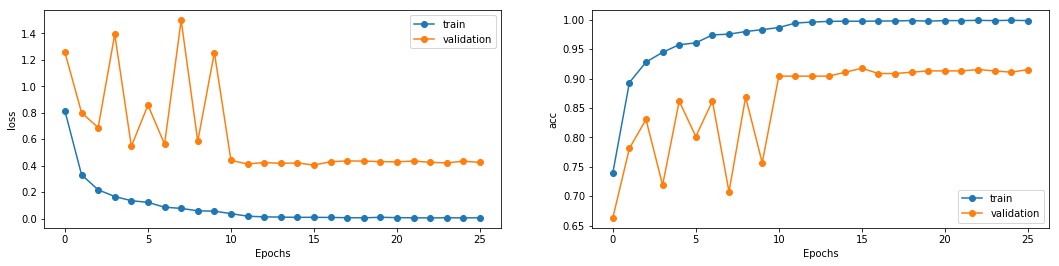

In [54]:
# 透過趨勢圖來觀察訓練與驗證的走向 (特別去觀察是否有"過擬合(overfitting)"的現象)

import matplotlib.pyplot as plt

def plot_train_history(history, train_metrics, val_metrics):
    plt.plot(history.history.get(train_metrics),'-o')
    plt.plot(history.history.get(val_metrics),'-o')
    plt.ylabel(train_metrics)
    plt.xlabel('Epochs')
    plt.legend(['train', 'validation'])
    
plt.figure(figsize=(18,4))
plt.subplot(1,2,1)
plot_train_history(history, 'loss','val_loss')

plt.subplot(1,2,2)
plot_train_history(history, 'acc','val_acc')

plt.show()


In [55]:
'''import matplotlib.pyplot as plt

# Loss Curves
plt.figure(figsize=[8,6])
plt.plot(history.history['loss'],'r',linewidth=3.0)
plt.plot(history.history['val_loss'],'b',linewidth=3.0)
plt.legend(['Training loss', 'Validation Loss'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Loss',fontsize=16)
plt.title('Loss Curves',fontsize=16) 

# Accuracy Curves
plt.figure(figsize=[8,6])
plt.plot(history.history['acc'],'r',linewidth=3.0)
plt.plot(history.history['val_acc'],'b',linewidth=3.0)
plt.legend(['Training Accuracy', 'Validation Accuracy'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Accuracy',fontsize=16)
plt.title('Accuracy Curves',fontsize=16)
'''

"import matplotlib.pyplot as plt\n\n# Loss Curves\nplt.figure(figsize=[8,6])\nplt.plot(history.history['loss'],'r',linewidth=3.0)\nplt.plot(history.history['val_loss'],'b',linewidth=3.0)\nplt.legend(['Training loss', 'Validation Loss'],fontsize=18)\nplt.xlabel('Epochs ',fontsize=16)\nplt.ylabel('Loss',fontsize=16)\nplt.title('Loss Curves',fontsize=16) \n\n# Accuracy Curves\nplt.figure(figsize=[8,6])\nplt.plot(history.history['acc'],'r',linewidth=3.0)\nplt.plot(history.history['val_acc'],'b',linewidth=3.0)\nplt.legend(['Training Accuracy', 'Validation Accuracy'],fontsize=18)\nplt.xlabel('Epochs ',fontsize=16)\nplt.ylabel('Accuracy',fontsize=16)\nplt.title('Accuracy Curves',fontsize=16)\n"

In [61]:
scores = model.evaluate(X_test, y_test)

scores[1]

448/448 [==============================] - 4s 8ms/step


0.9174107142857143

In [62]:
import os
from pathlib import PurePath # 處理不同作業系統file path的解析問題 (*nix vs windows)

# 載入要驗證模型的數據
def load_test_set(path):
    pics, labels , img_name = [], [],[]
    #reverse_dict = {v:k for k,v in map_characters.items()}
    for pic in glob.glob(path+"/"+'*.jpg'):
       
        #char_name = "_".join(os.path.basename(pic).split('_')[:-1])
        #if char_name in reverse_dict:
            temp = cv2.imread(pic)  #轉灰階
            temp = cv2.cvtColor(temp, cv2.COLOR_BGR2RGB)
            #temp = cv2.cvtColor(temp, cv2.COLOR_BGR2GRAY)
            temp = cv2.resize(temp, (img_height,img_width))
            #temp = np.expand_dims(temp, axis=2) #增加一個維度
            temp = temp.astype('float32') / 255.
            
            pics.append(temp)
        #    labels.append(reverse_dict[char_name])
            labels.append(1) #預設都是1
            #print(os.path.basename(pic).split('.jpg')[0])
            img_name.append (os.path.basename(pic).split('.jpg')[0])
            
            
    X_test = np.array(pics)
    y_test = np.array(labels)
    y_test = keras.utils.to_categorical(y_test, num_classes) # 進行one-hot編碼
    print("Test set", X_test.shape, y_test.shape)
    return X_test, y_test , img_name

imgsPath = data_dir_path+"/testset"

#載入數據
X_valtest, y_valtest , name_valtest = load_test_set(imgsPath)


Test set (1500, 224, 224, 3) (1500, 15)


In [63]:

#print(X_valtest[5])
print(name_valtest[1])

00317b9d4bed4a2b1017e2bd31b9bf2f25bad05a65f570bb88085b3484a50afc


In [64]:
print(imgsPath)
os.chdir('/home/jovyan/may_the_4_be_with_u')

/data/examples/may_the_4_be_with_u/where_am_i/testset


In [65]:
# 預測與比對
from keras.models import load_model

# 把訓練時val_loss最小的模型載入
model = load_model('model-dtaug.h5')



In [66]:
y_valtest

array([[ 0.,  1.,  0., ...,  0.,  0.,  0.],
       [ 0.,  1.,  0., ...,  0.,  0.,  0.],
       [ 0.,  1.,  0., ...,  0.,  0.,  0.],
       ..., 
       [ 0.,  1.,  0., ...,  0.,  0.,  0.],
       [ 0.,  1.,  0., ...,  0.,  0.,  0.],
       [ 0.,  1.,  0., ...,  0.,  0.,  0.]], dtype=float32)

In [79]:
y_valtest.shape[0]

1500

In [93]:
# 預測與比對
#y_pred = model.predict_classes(X_valtest)

y_pred_class = model.predict(X_valtest)
y_perd_argmax = []  # 1500

for i in range(0 ,1500):
    y_perd_argmax.append(np.argmax(y_pred_class[i]))

acc = np.sum(y_perd_argmax==np.argmax(y_valtest, axis=1))/np.size(y_perd_argmax)
print("Test accuracy = {}".format(acc))




Test accuracy = 0.064


In [95]:
#y_perd_argmax
#X_valtest


In [98]:
y_perd_argmax[15]

5

In [100]:
submission_dict = dict(zip(name_valtest , y_perd_argmax))
submission_tb = pd.DataFrame(list(submission_dict.items()), columns=['id','class'])

In [101]:
os.getcwd()
os.chdir('//home/jovyan/may_the_4_be_with_u')
submission_tb.to_csv('submission_keras.csv',index=False)